In [149]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pre_processing import preprocess_tweet

# Constants
data_dir = "./data"
vocab_size = 10000  # Only consider the top 10k words
max_input_len = 25  # max number of words in a sentece
learning_rate = 0.0001
epochs = 20
batch_size = 40
test_size = 0.2

# Labels/Target: categories to predict
target_label_mapping = {"neutral": 0, "positive": 1, "negative": 2}

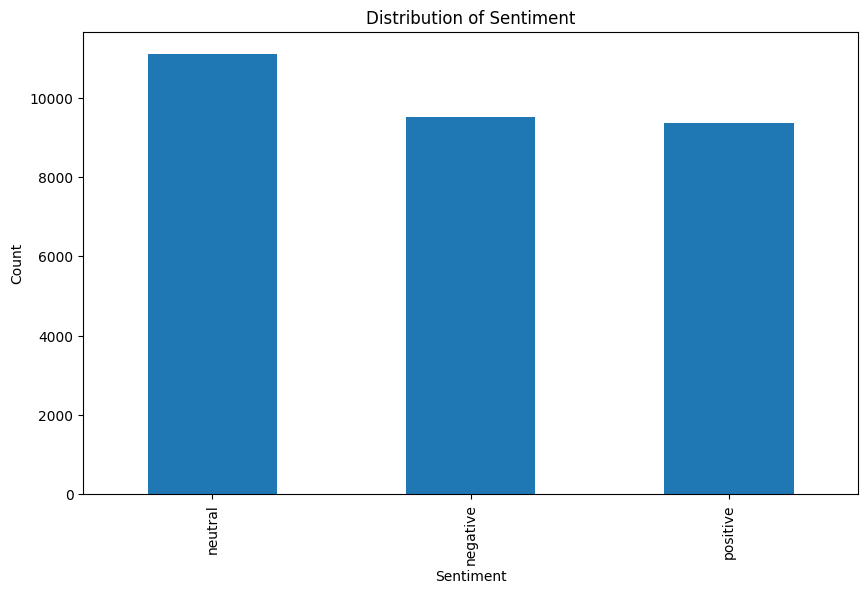

In [150]:
# Load dataset


# Using a subset of the dataset because most of the samples are positive and negative,
# and it is recommended to have a balanced dataset
df = pd.read_csv(f"{data_dir}/processed_tweets.csv", nrows=30000)
df["processed_text"] = df["processed_text"].astype(str)


plt.figure(figsize=(10, 6))
df['target'].value_counts().plot(kind='bar')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [151]:
# Data Preparation

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df["processed_text"])

"""
This function will convert a given sentence into tokenized padded sequence to
be input in the model.
Example:
    - "I love the new design of this car!" -> [1, 2, 3, 4, 5, 6, ... n]
"""


def transform_to_model_input(text_data: list[str] | list[list[str]]) -> np.ndarray:
    sequences = tokenizer.texts_to_sequences(text_data)
    return pad_sequences(
        sequences, maxlen=max_input_len, padding="post", truncating="post"
    )


input_data = transform_to_model_input(df["processed_text"])

# Convert to one-hot encoding
labels = df["target"].map(target_label_mapping).values
labels = tf.keras.utils.to_categorical(labels, num_classes=3)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    input_data, labels, test_size=test_size, random_state=42
)

In [152]:
# Pre-Trained embeddings
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    return embeddings_index


glove_file_path = f"{data_dir}/glove.twitter.27B.25d.txt"
embeddings_index = load_glove_embeddings(glove_file_path)


def create_embedding_matrix(word_index, embeddings_index, embedding_dim, vocab_size):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix


# Create embedding matrix
# This matrix will be used as input weights for the embedding layer in the model
embedding_matrix = create_embedding_matrix(
    tokenizer.word_index, embeddings_index, max_input_len, vocab_size
)

In [153]:
# Create a CNN model for text classification
def create_cnn_model():
    model = models.Sequential()

    # Embedding layer
    # Make use of pre-trained embeddings as weights for the embedding layer (GloVe)
    model.add(
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=max_input_len,
            weights=[embedding_matrix],
            trainable=False,
        )
    )

    # Convolutional layer: using filter sizes equivalent to detecting n-grams (e.g., n=3)
    # In this case: 512 different combinations of 4 words (4-gram)
    model.add(
        layers.Conv1D(filters=512, kernel_size=4, activation="relu")
    )  # Acts as n-gram detector
    model.add(layers.GlobalMaxPooling1D())  # Pool over the entire sequence

    # Add dropout for regularization
    model.add(layers.Dropout(0.5))

    # Fully connected (dense) layer
    model.add(layers.Dense(512, activation="relu"))

    # Add another dropout layer
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(3, activation="softmax"))

    # Compile the model with appropriate loss and optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [154]:
# Train the CNN model
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

cnn_model = create_cnn_model()
history = cnn_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    callbacks=[early_stopping],
    batch_size=batch_size,
    validation_data=(X_test, y_test),
)

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5267 - loss: 0.9877 - val_accuracy: 0.6723 - val_loss: 0.7623
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6663 - loss: 0.7741 - val_accuracy: 0.6908 - val_loss: 0.7188
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6849 - loss: 0.7288 - val_accuracy: 0.6985 - val_loss: 0.6994
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6997 - loss: 0.7037 - val_accuracy: 0.7042 - val_loss: 0.6911
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7049 - loss: 0.6883 - val_accuracy: 0.7127 - val_loss: 0.6740
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7107 - loss: 0.6824 - val_accuracy: 0.7153 - val_loss: 0.6691
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7181 - loss: 0.6638 - val_accuracy: 0.7150 - val_loss: 0.6592
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7219 - loss: 0.6508 - val_accuracy: 0.

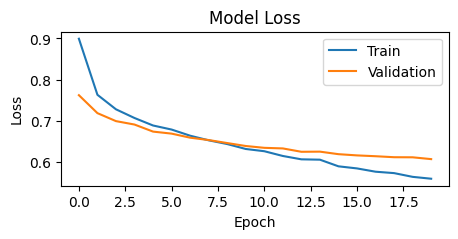

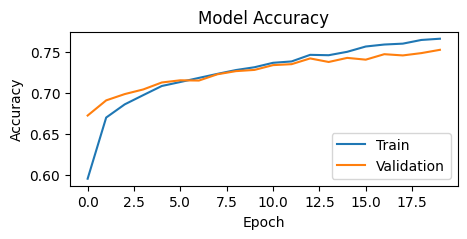

In [155]:
# Performance evaluation

# Summarize history for loss
plt.figure(figsize=(5, 2))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(5, 2))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="lower right")
plt.show()

In [156]:
# Evaluate the model on the test data
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7519 - loss: 0.6079
Test Accuracy: 0.7524999976158142


In [157]:
# Manual testing

tweets = [
    "I love the new design of this car!",
    "The weather today is just okay.",
    "I'm so disappointed with the service I received.",
    "This movie was absolutely fantastic!",
    "The food was mediocre at best.",
    "I can't believe how rude the staff was.",
    "What a beautiful day!",
    "The product quality is just average.",
    "I'm really unhappy with my purchase.",
    "This place is amazing!",
    "The event was neither good nor bad.",
    "I'm so frustrated with the delays.",
    "Had a great time with friends!",
    "The meeting was quite boring.",
    "I'm very upset with the outcome.",
    "This is the best experience I've ever had!",
    "The presentation was just fine.",
    "I'm extremely dissatisfied with the service.",
    "Feeling so happy and content!",
    "The performance was just okay.",
]

mask_label_mapping = {
    "neutral": "neutral 😐",
    "positive": "positive 👍",
    "negative": "negative 👎",
}

predictions = []
for t in tweets:
    cleaned_text = preprocess_tweet(t)
    transformed = transform_to_model_input([cleaned_text])
    model_predictions = cnn_model.predict([transformed])

    prediction = {}
    prediction["tweet"] = t
    t_predictions = zip(
        [k for k, v in target_label_mapping.items()], list(model_predictions[0])
    )

    max_index = np.argmax(model_predictions)

    predicted_sentiment = list(mask_label_mapping.values())[max_index]

    for t_prediction in t_predictions:
        target_label, class_pred_value = t_prediction
        maked_class_label = mask_label_mapping[target_label]
        prediction[maked_class_label] = class_pred_value
    
    prediction["predicted_sentiment"] = predicted_sentiment
    predictions.append(prediction)


predictions_df = pd.DataFrame(predictions)
predictions_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


,tweet,neutral 😐,positive 👍,negative 👎,predicted_sentiment
0,I love the new design of this car!,0.076964,0.909692,0.013344,positive 👍
1,The weather today is just okay.,0.768849,0.063260,0.167890,neutral 😐
2,I'm so disappointed with the service I received.,0.386345,0.259673,0.353982,neutral 😐
3,This movie was absolutely fantastic!,0.010365,0.980611,0.009024,positive 👍
4,The food was mediocre at best.,0.385041,0.441731,0.173228,positive 👍
5,I can't believe how rude the staff was.,0.286949,0.119619,0.593432,negative 👎
6,What a beautiful day!,0.004464,0.988864,0.006672,positive 👍
7,The product quality is just average.,0.538918,0.104840,0.356241,neutral 😐
8,I'm really unhappy with my purchase.,0.097464,0.086651,0.815884,negative 👎
9,This place is amazing!,0.001963,0.996878,0.001158,positive 👍
